Conformer (convolutional+transformer networks) is a type of network frequently used for ASR and other problems that entail processing signal data. Hence, this notebook is not only going to be dedicated to building such a network from scratch, but also to signal processing techniques and theory behind them.

#### Intuitive explanation of ADC (Analog to Digital Conversion)
A slight diversion is needed in order to fully grasp the concept of "sound" in ML. Thanks to [Valerio Velardo](https://www.youtube.com/@ValerioVelardoTheSoundofAI) we're able to intuitively understand the entirety of the backbone of signal processing. A sound is the compression of particles in the air under some pressure, which can be represented as the graph with Y values corresponding to the level of compression (amplitude) and X values corresponding to time:

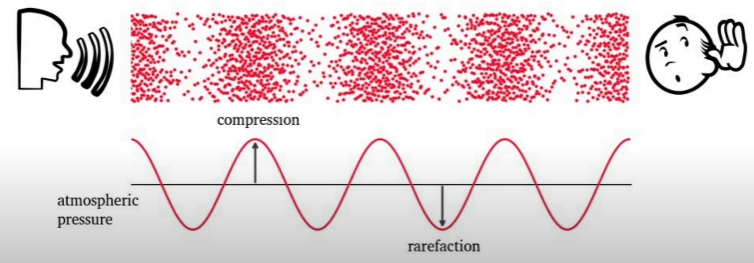


A machine is sampling amplitude values across the sound wave with some sampling rate (or a frequency) $sr=\frac{1}{T}$ (which creates a so-called "sampling error"), where $T$ is the period:

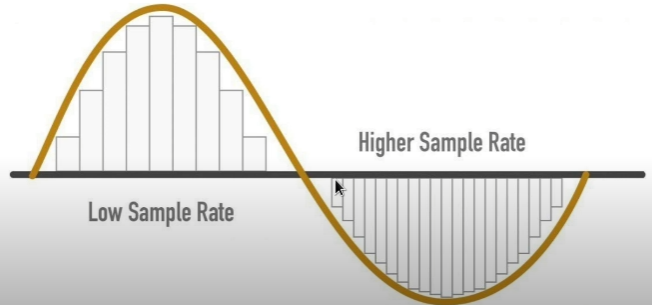

#### Why do we frequently use hard-coded sampling rates (frequencies)? 

Human's hearing range is limited by approx $20000 Hz$ (our mortal brains are not able to percieve more information that that). Hence, for example, the CD recording's frequency stands on $44100 Hz$, because $\frac{44100}{2}=22050$ ($\text{div } 2$ represents the sampling rate of upper&lower bounds of the wave), which is the furthest a human ear can interpret. This ensures that there are no "artifacts" left in the recording.

#### What is an artifact?

An artifact $A$ is a lost piece of information that we're not aware of, because of the mismatch in frequencies:

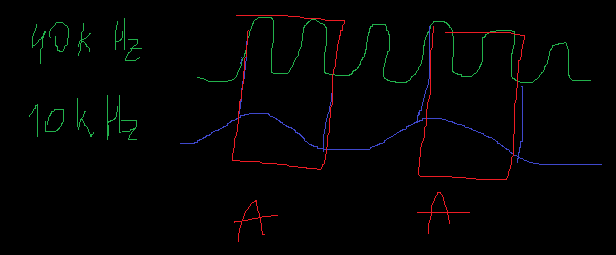

#### Practical ADC: Quantization

* Apply the same sampling technique described previously;
* Instead of continuos distribution of amplitudes on the y axis, we convert them to a descrete distribution based on the constraint in bits, i.e. for 4-bit representation ($Q=4$ is quantization depth) we would have $aplitude\in\{0000,0001,0010,...,1111\}$;
* Having a constrained descrete distribution denoted as $W$, each sampled amplitude is rounded up to the nearest value from the $W$. Hence, on top of the "sampling error" now we would also introduce the "quantization error";
* Having quantified our amplitudes we can now calculate mem size the is needed to store 1min of recording of some frequency $F$: $4_{bits}\times F\times60$ (bits).

#### Can we extract hardware limitations under quantization contraint?
Having introduced bit depth as a quantization constraint we can now get an approximate value for the "dynamic range" (of how big of a soundwave change in $dB$ the system is able to comprehend without any problems): $6,02\times Q$

#### Framing and its purpose
We're not really reading raw text Frames our sliding windows over samples, that intersect with each other:

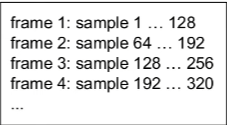

Each frame's duration can be calculated by the formula: $d_f=\frac{1}{s_r}K$, where $K$ - frame size.

Human's ear is scientifically able to interpret sounds of duration of at leat $10ms$, hence the frame size for that matter is usually defined by 512 samples as $\frac{1}{44100}\times512=11,6ms$. This is the main **purpose** of frames.

Each frame also undergoes preliminary smoothing (just like exponent smoothing in simple time series, however in audio processing it is usually hann window), in order to account for the stochasticity of the soundwave.

#### Why do frames overlap?
After applying frame-by-frame smoothing we might loose some information. Hence we combine two smoothed graphs in order to get a combined distribution of amplitudes. Same idea is also used in GMM, which you can find in `ml/unsupervised/gmm.ipynb`:

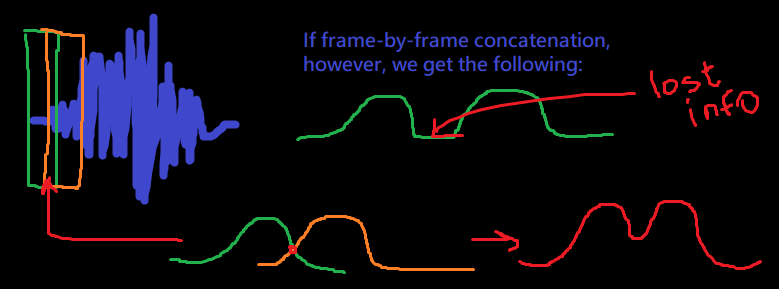

#### General frequency-domain feature extraction pipeline
Now, having explained all the preliminary concepts we can formulate the following pipeline for audio features' extraction:

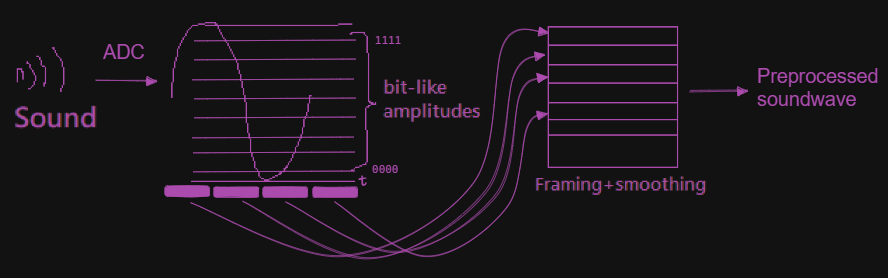

We can now put this little knowledge to the test on the sample of the Thom Yorke's Suspirium:

In [8]:
import IPython.display as ipd
ipd.Audio('./data/audio/thom_yorke.mp3')

In [19]:
# to read a quantized soundwave as well as
# the frequency (sample rate) we use 
# a librosa library

import librosa

soundwave, sample_rate = \
    librosa.load('./data/audio/thom_yorke.mp3')
print(soundwave.shape, sample_rate)

(675169,) 22050


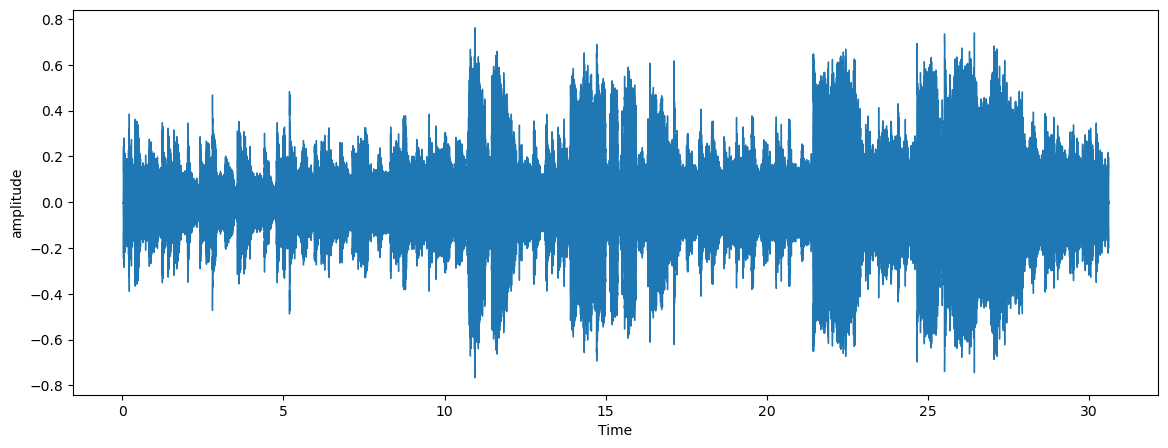

In [38]:
# plotting a waveplot can be done with
# librosa.display.waveplot

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
librosa.display.waveshow(soundwave, sr=sample_rate)
plt.ylabel('amplitude')
None

We can also see for ourselves how having big "artifacts" affects the initial recording. For that matter we can load the same recording but with the sample rate slashed by 10 units. It becomes muffled and in fact compressed by $90\%$ (% of artifacts gained as a result, that in the case of librosa is defined by the change of sizes of numpy arrays) compared to the original sample rate of $22k$:

(67517,) 2205
% of artifacts: 90.0


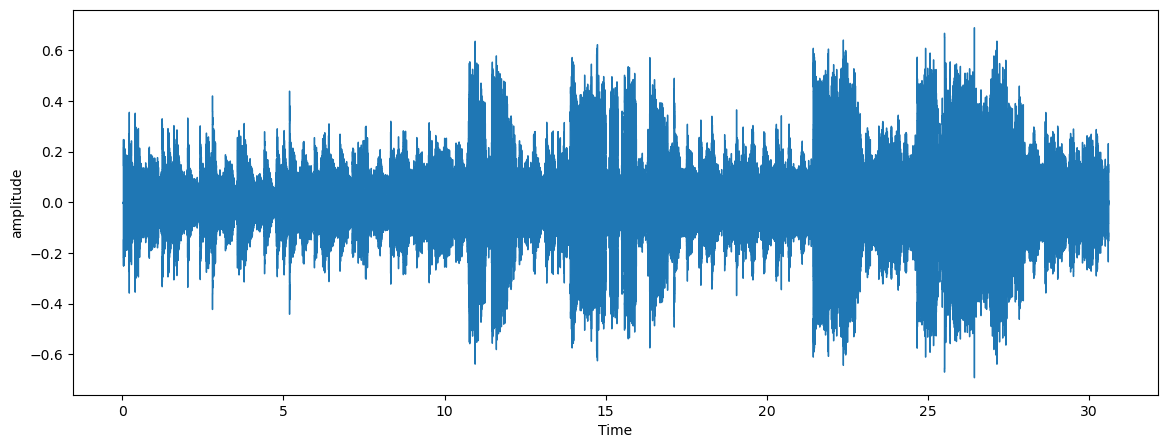

In [40]:
wave_w_artifacts, sample_rate_slashed = \
    librosa.load('./data/audio/thom_yorke.mp3', sr=sample_rate//10)
print(wave_w_artifacts.shape, sample_rate_slashed)
lost_info = round((soundwave.shape[0] - wave_w_artifacts.shape[0]) /\
    soundwave.shape[0]*100, 2)
print(f'% of artifacts: {lost_info}')

plt.figure(figsize=(14,5))
librosa.display.waveshow(wave_w_artifacts, sr=sample_rate_slashed)
plt.ylabel('amplitude')
None

In [36]:
ipd.Audio(wave_w_artifacts,rate=sample_rate_slashed)

However, if we slash the sample rate upon displaying an existing presampled soundwave, this would yeild an interesting result of either limiting or expanding an amount of information we're able to comprehend per 1 unit depending on whether we decrease or increase our sample rate accordingly:

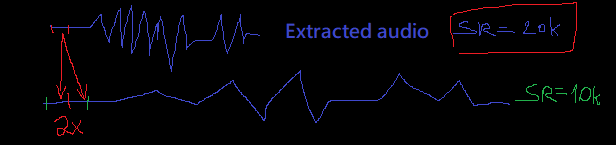

In [14]:
# what would happen if we slash our sample rate by 2
# time increases x 2, because now we're limiting our
# "comprehension" potential by 2 less the information

ipd.Audio(soundwave, rate=sample_rate//2)

#### RMS Energy (RMSE) 
RMS Energy is used to calculate an energy of each frame in the scope of the whole recording. It could give a more meaningful perspective, because it averages all points as well as takes a square root of them within a frame, which scopes them out to not only positive values, but smaller ones as well:
$$
RMS_{frame}=\sqrt{\frac{1}{K}\sum_{k=frame\times K}^{(frame+1)K-1}s(k)^2}
$$

In [48]:
import numpy as np

def rmse(wave, frame_len, hop_len):
    """ 
    Root-Mean Sqaured Energy

    frame_len: N of items in each frame
    hop_len: sliding window step
    """

    rmse = []

    for i in range(0,len(wave),hop_len):
        rmse_cur_frame = ((wave[i:i+frame_len])**2).mean()**.5
        rmse.append(rmse_cur_frame)
    
    return rmse

Having introduced RMSE calculation we can now compare it with the one available in the librosa API:

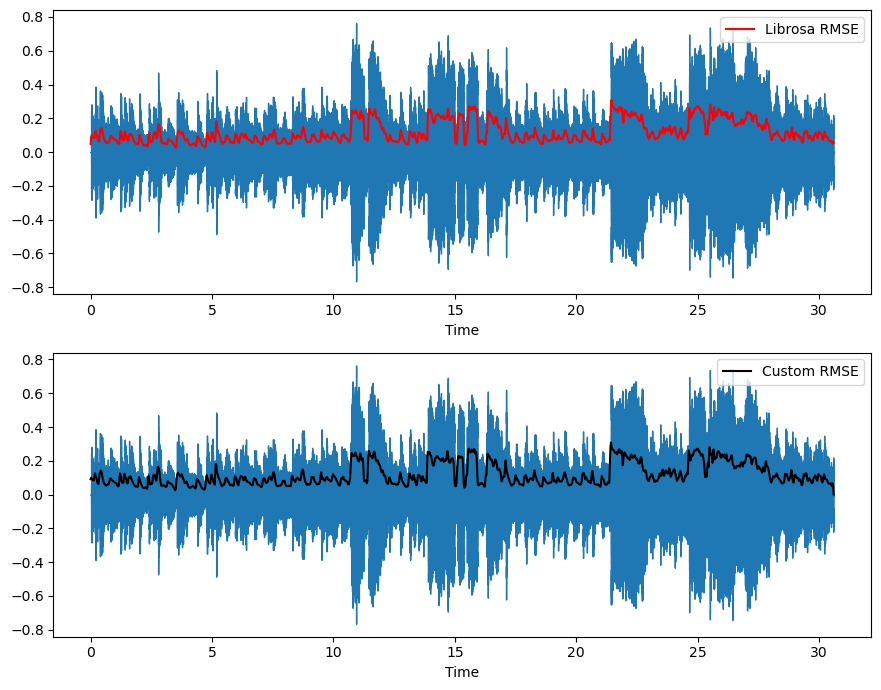

In [54]:
FRAME_LEN, HOP_LEN = 1024, 512

# librosa RMSE calculation
rmse_librosa = librosa.feature.rms(
    y=soundwave, frame_length=FRAME_LEN, hop_length=HOP_LEN)[0]

# custom implementation
rmse_custom = rmse(soundwave,FRAME_LEN,HOP_LEN)

# mapping each frame to the timestep point on the x axis
t = librosa.frames_to_time(range(len(rmse_librosa)),
                           hop_length=HOP_LEN)

fig, axs = plt.subplots(2,1,figsize=(9,7))
librosa.display.waveshow(soundwave, 
                         sr=sample_rate,
                         ax=axs[0])
axs[0].plot(t, rmse_librosa,label='Librosa RMSE',c='red')
axs[0].legend(loc='best')
librosa.display.waveshow(soundwave, 
                         sr=sample_rate,
                         ax=axs[1])
axs[1].plot(t, rmse_custom,label='Custom RMSE',c='black')
axs[1].legend(loc='best')
fig.tight_layout()

#### ZCR (Zero Crossing Rate)
ZCR graph tells us the intesity of frequencies over time in the recording (how much the waveplot crosses the zero mark tells us how high is the frequency). In the context of Thom Yorke's Suspirium (who is famous for using arrythmic sequences), spikes show us an introduction of a new uncorrelated soundwave that is a vocal part of the song:

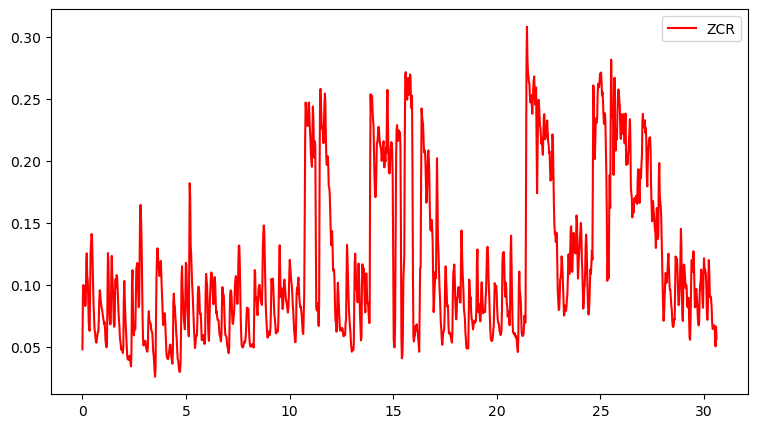

In [56]:
zcr = librosa.feature.rms(
    y=soundwave, frame_length=FRAME_LEN, hop_length=HOP_LEN)[0]

# mapping each frame to the timestep point on the x axis
t = librosa.frames_to_time(range(len(rmse_librosa)),
                           hop_length=HOP_LEN)

plt.figure(figsize=(9,5))
plt.plot(t, rmse_librosa,label='ZCR',c='red')
plt.legend(loc='best')